## load training triples

In [1]:
import json


with open('training_data_pairs_shuffled.json', 'r') as f:
    loaded_data = json.load(f)

In [2]:
#loaded_data = loaded_data['train_data'] + loaded_data['test_data'] + loaded_data['val_data']

In [3]:
print(loaded_data[0])

{'anchor': {'id': 1, 'features': 'Adventure Shooter Simulator Action Fantasy Stealth actionadventure blackjack bowandarrow crime darkness death difficultylevel ghosts immersive invisibility melee movingbodies pacifistplaythrough particlesystem pickpocketing polygonald potion realtimecombat shadowstealth singleplayeronly stealthkill steampunk swimming swordplay theft thief', 'description': 'ultimate thief back tread softly make complex non-linear levels full loot steal guards outsmart improved enemy gadgets riveting story draw world thief metal place powerful technologies fanatical religions corruption game begins garrett continues life thief however betrayed fence ambushed early mission determines truart local sheriff hunting keepers take garrett hear prophecy metal ignores garrett leaves keepers informs truart hired kill gives garrett letter directs eavesdrop mechanist meeting garrett overhears truart father karras discussing conversion street people mindless servants wear masks emit 

In [4]:
print(f'length: {len(loaded_data)}')

length: 283131


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def extract_features_and_labels(data):
    features_anchor = [entry['anchor']['features'] for entry in data]
    features_game = [entry['game']['features'] for entry in data]
    labels = [entry['label'] for entry in data]
    return (features_anchor, features_game, labels)

features_anchor, features_game, labels = extract_features_and_labels(loaded_data)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(features_anchor + features_game)
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max(
        max(len(seq) for seq in features_anchor),
        max(len(seq) for seq in features_game),
    )

def tokenize_and_pad(sequences):
    tokenized_sequences = tokenizer.texts_to_sequences(sequences)
    padded_sequences = pad_sequences(tokenized_sequences, maxlen=max_sequence_length, padding='post')
    return padded_sequences


features_anchor = tokenize_and_pad(features_anchor)
features_game = tokenize_and_pad(features_game)

2024-01-27 21:54:42.241081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 21:54:42.241107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 21:54:42.241846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 21:54:42.246752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 21:54:43.020789: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split

train_anchor, temp_anchor, train_game, temp_game, train_labels, temp_labels = train_test_split(
    features_anchor,
    features_game,
    labels,
    test_size=0.8, random_state=42)
val_anchor, test_anchor, val_game, test_game, val_labels, test_labels = train_test_split(
    temp_anchor,
    temp_game,
    temp_labels,
    test_size=0.5, random_state=42)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


def build_siamese_network(input_shape, vocab_size):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=input_shape))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='sigmoid'))
    return model

# Define the input shapes
input_shape = max_sequence_length

# Create the Siamese network
anchor_input = tf.keras.Input(shape=(input_shape,), name='anchor')
game_input = tf.keras.Input(shape=(input_shape,), name='game')

siamese_network = build_siamese_network(input_shape, vocab_size)

# Generate the encodings (feature vectors) for the anchor and game
encoded_anchor = siamese_network(anchor_input)
encoded_game = siamese_network(game_input)

# Calculate the similarity between the anchor and game
similarity = layers.Dot(axes=1, normalize=True)([encoded_anchor, encoded_game])
#layers.CosineSimilarity()

# Create the Siamese model
siamese_model = tf.keras.Model(inputs=[anchor_input, game_input], outputs=similarity)

# Compile the Siamese model with binary crossentropy loss
custom_adam = Adam(learning_rate=0.001)
siamese_model.compile(loss='binary_crossentropy', optimizer=custom_adam, metrics=['accuracy'])

# Print the model summary
print(siamese_model.summary())

2024-01-27 21:54:59.493295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-27 21:54:59.517081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-27 21:54:59.517224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 3764)]               0         []                            
                                                                                                  
 game (InputLayer)           [(None, 3764)]               0         []                            
                                                                                                  
 sequential (Sequential)     (None, 16)                   466496    ['anchor[0][0]',              
                                                                     'game[0][0]']                
                                                                                                  
 dot (Dot)                   (None, 1)                    0         ['sequential[0][0]',      

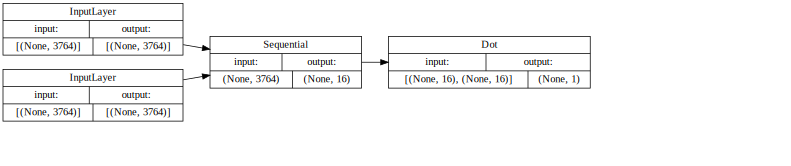

In [8]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(
    siamese_model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(siamese_model, rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Train the Siamese model with your padded_sequences_anchor, padded_sequences_game, and labels
history = siamese_model.fit(
    [train_anchor, train_game],
    np.array(train_labels),
    epochs=10,
    batch_size=64,
    #validation_split=0.2,
    use_multiprocessing=True,
    workers=10,
    validation_data=([val_anchor, val_game], np.array(val_labels))
)

In [ ]:
from tensorflow.keras.models import save_model

siamese_model.save('siamese_model.keras')

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = siamese_model.evaluate(
    (test_anchor, test_game),
    np.array(test_labels),
)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# from tensorflow.keras.models import load_model
# 
# siamese_model = load_model("siamese_model.h5")

In [ ]:
# get item by id
# anchor_game = {'id': 26715, 'features': 'Adventure Arcade Indie Platform Racing Action abstract cyberpunk fastpaced precisionplatforming shootemup speedrunmode superhero'}
# 
# item_sequences = tokenizer.texts_to_sequences([anchor_game['features']])
# padded_item_sequences = pad_sequences(item_sequences, maxlen=max_sequence_length, padding='post')

In [ ]:
# get all items